<h1 style='font-size:3rem;colour:red;'>Sales Forecasting</h1>

The purpose of this notebook is to evaluate the data of weekly sales for a retail supply chain using Python. I will analyze some of the best/worst performing Weeks. As well, correlate the seasonal/holiday sales with the data, in order to get insight on the increase in sales during the holidays.

# Import libraries

In [357]:
import pandas as pd                    
import csv  
import seaborn as sns
import numpy as np                      
import matplotlib.pyplot as plt  
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import datetime
import time
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf

# Analyzing data

In [358]:
df= pd.read_csv("CN_sales_forecasting.csv")
df['Date'] = pd.to_datetime(df['Date'])## change Date to datetime format

In [359]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-05-02,24924.50,False
1,1,1,2010-12-02,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-05-03,21827.90,False


In [360]:
df.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


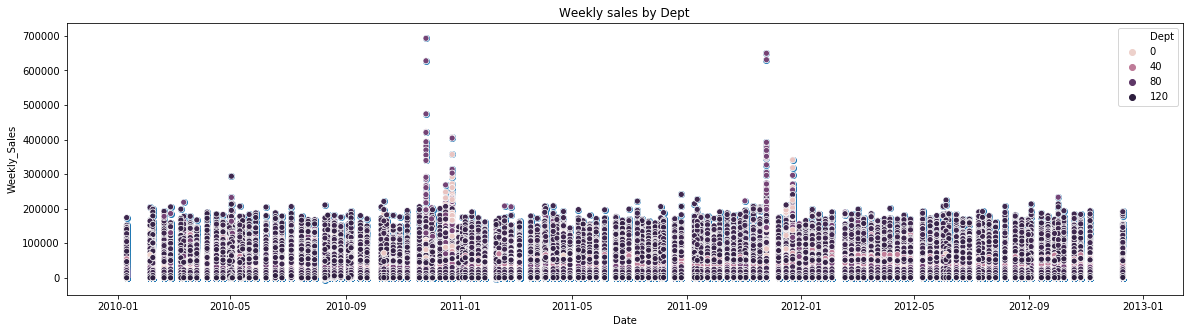

In [361]:
plt.figure(figsize=(20,5))
plt.scatter(df['Date'],df['Weekly_Sales'])
sns.scatterplot(data=df, x='Date', y='Weekly_Sales', hue='Dept')
plt.xlim=(2010, 2013)
plt.ylim=(0, 700000)
plt.title('Weekly sales by Dept')
plt.show()

This graph has too many data points, thus I will simplify and check for duplicates.

In [362]:
df_dup=df[df.duplicated()]
print("\n\nDuplicate Rows : \n {}".format(df_dup))



Duplicate Rows : 
 Empty DataFrame
Columns: [Store, Dept, Date, Weekly_Sales, IsHoliday]
Index: []


# View Store 1 Dept 1

Text(0.5, 1.0, 'Store 1 Dept 1')

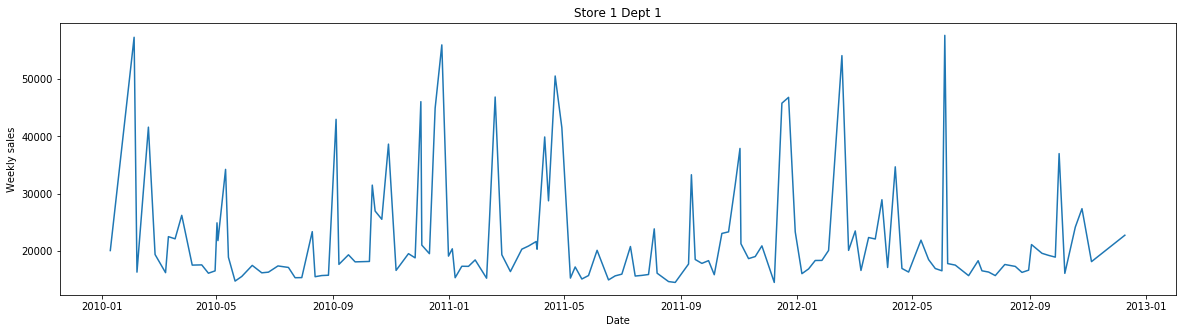

In [363]:
df1= df[df['Store']==1]
Store1Dept1=df1[df1['Dept']==1]
Store1Dept1= Store1Dept1.sort_values('Date', ascending=False)
plt.figure(figsize=(20,5))
plt.plot(Store1Dept1['Date'],Store1Dept1["Weekly_Sales"])
plt.ylabel('Weekly sales')
plt.xlabel('Date')
plt.title('Store 1 Dept 1')

# Average Sales per week for all stores

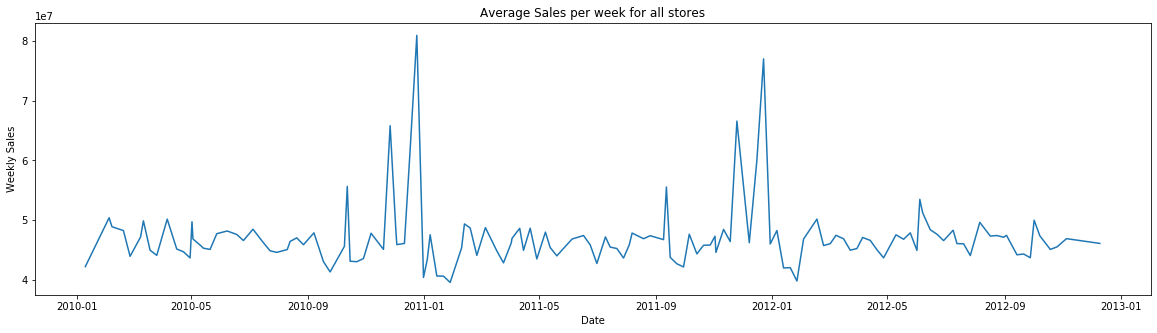

In [364]:
average_weekly_sales = df.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()
average_sales = average_weekly_sales.sort_values('Weekly_Sales', ascending=False)

plt.figure(figsize=(20,5))
plt.plot(average_weekly_sales['Date'],average_weekly_sales['Weekly_Sales'])

plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Average Sales per week for all stores')
plt.show()

# Top 5 weeks


In [365]:
average_sales.head() 

,Date,Weekly_Sales
46,2010-12-24,80931415.60
98,2011-12-23,76998241.31
95,2011-11-25,66593605.26
41,2010-11-26,65821003.24
45,2010-12-17,61820799.85


Best performing weeks is usually around Christmas

# Lowest 5 weeks

In [366]:
average_sales[::-1].head() 

,Date,Weekly_Sales
52,2011-01-28,39599852.99
103,2012-01-27,39834974.67
47,2010-12-31,40432519.00
51,2011-01-21,40654648.03
50,2011-01-14,40673678.04


Worst performing weeks is usually after the holidays

# Stores that have the highest sales

In [367]:
top_stores = df.groupby(by=['Store'], as_index=False)['Weekly_Sales'].sum()
top_stores.sort_values('Weekly_Sales', ascending=False)[:3]

,Store,Weekly_Sales
19,20,3.013978e+08
3,4,2.995440e+08
13,14,2.889999e+08


Store 20 has the highest sales

# Store 20


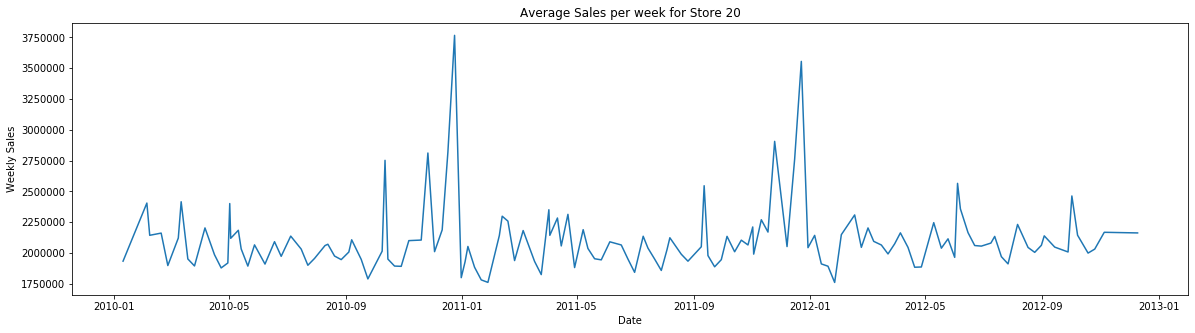

In [368]:
df20= df[df['Store']==20]
average_sales_week_20 = df20.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()
average_sales_20 = average_sales_week_20.sort_values('Weekly_Sales', ascending=False)

plt.figure(figsize=(20,5))
plt.plot(average_sales_week['Date'],average_sales_week['Weekly_Sales'])

plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Average Sales per week for Store 20')
plt.show()

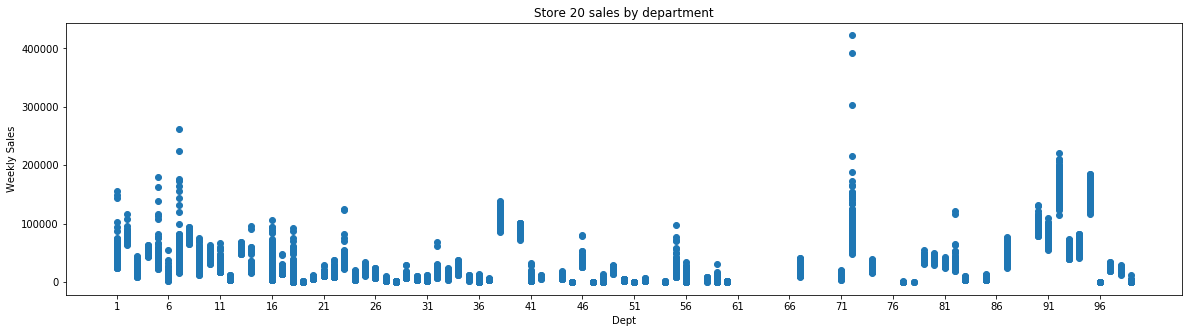

In [369]:
plt.figure(figsize=(20,5))
plt.scatter(df20['Dept'],df20['Weekly_Sales'])
x=df20['Dept']
plt.xlabel('Dept')
plt.ylabel('Weekly Sales')
plt.title('Store 20 sales by department')
plt.xticks(np.arange(min(x), 100, 5))
plt.show()

Store 20 Department 72 is the best performing Department in the best performing Store.

We can estimate that weekly sales is depandant on holiday, but by how much? I will use correlation to view the depandacent of sales on holidays.

# Autocorrelation and Partial Autocorrelation for Average Sale per week

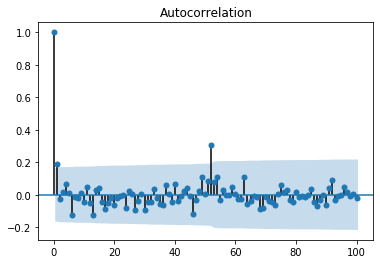

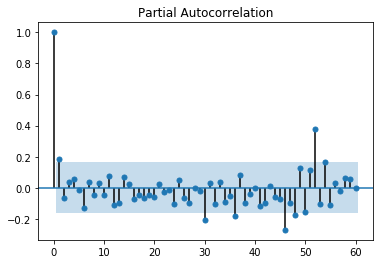

In [370]:
ts = average_sales_week.set_index('Date')
plot_acf(ts,lags=100)
plot_pacf(ts,lags=60)
plt.show()

# Model

In [371]:
def season_model(ts, peak):
    X=np.array([ ts.values[(i-peak)].squeeze() if i >= np.max(peak) else np.array(len(peak) * [np.nan]) for i in range(len(ts))])
    M= ~np.isnan(X[:,:1]).squeeze()
    Y=ts.values
    LR=LinearRegression()
    LR.fit(X[M],Y[M])
    print(LR.coef_)
    print('Score factor: %.2f' % LR.score(X[M],Y[M])) 
    return LR.coef_, LR.intercept_

def Pmodel(ts, peak, coef, intercept):
     return np.array([np.sum(np.dot(coef, ts.values[(i-peak)].squeeze())) + intercept  if i >= np.max(peak) else np.nan for i in range(len(ts))])

[[ 0.11263901 -0.05795337  0.47297099]]
Score factor: 0.33


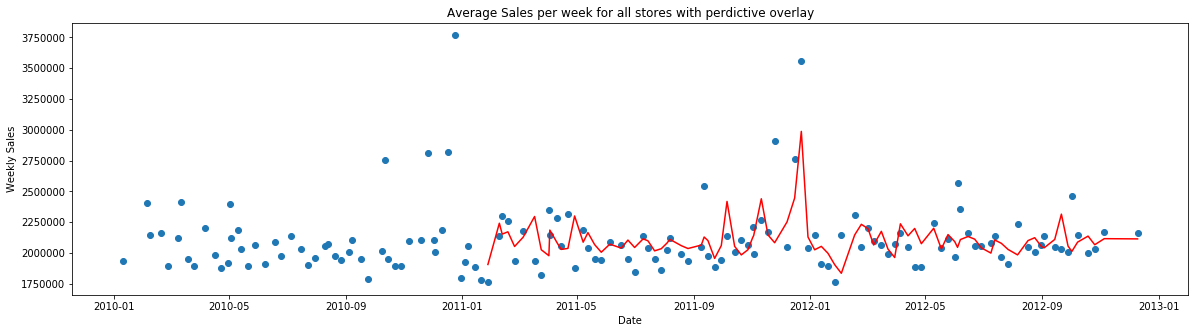

In [372]:
peak= np.array([1,6,52])
coef, intercept= season_model(ts,peak)
P=pd.DataFrame(index=ts.index, data=Pmodel(ts, peak, coef, intercept))
plt.figure(figsize=(20,5))
plt.plot(ts,'o')
plt.plot(P,c='red')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Average Sales per week for all stores with perdictive overlay')
plt.show()

We got the coefficients, therefore Weekly sales is variable to the Holidays. During Christmas holidays, you can expect an 47% increase in sales and a decrease of 6% after the holidays.
Now we can get the difference between the real value and the predicted.

Mean difference and Standard deviation difference is: avg -0.01, std 0.09


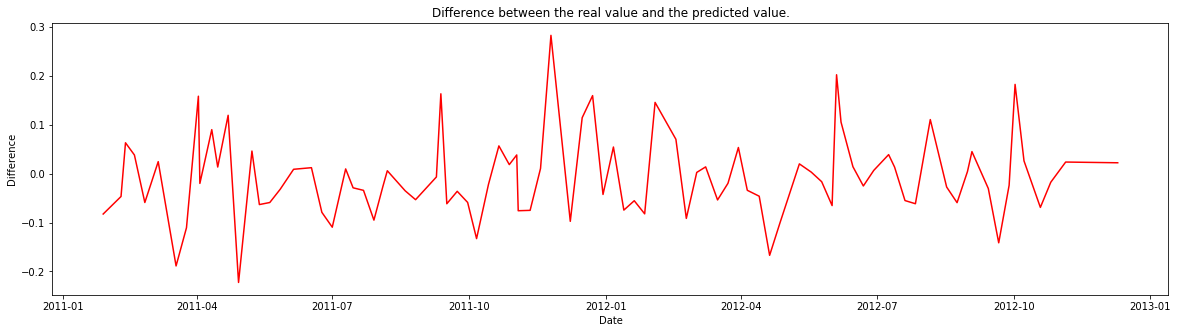

In [373]:
Accuracy=(ts['Weekly_Sales']-P[0])/ts['Weekly_Sales']

print('Mean difference and Standard deviation difference is: avg %.2f, std %.2f' % (Accuracy.mean(), Accuracy.std()))
 
plt.figure(figsize=(20,5))
plt.plot(Accuracy, c='red')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.title('Difference between the real value and the predicted value.')
plt.show()

# Conclusion

With the data provided, we can see that sales are seasonal as intially setd. The average Weekly sales is $15981, with a standard deviation of 22711. The store with the highest sales is Store 20. Within Store 20, Department 72 has the highest sales.
The coefficients found are [ 0.11263901 -0.05795337  0.47297099]. Based on these coefficients we can predict how much the Weekly sales is dependant on Holidays. For example, during Christmas holidays, you can expect a 47% increase in sales.

# References

[1]"Retail sales forecast", Kaggle.com, 2022. [Online]. Available: https://www.kaggle.com/code/aremoto/retail-sales-forecast/notebook. [Accessed: 22- Apr- 2022].